# DQN, Deep Q Learning

In [1]:
import os
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple
from itertools import count
from PIL import Image

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display
    
plt.ion()

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

## Set Environment

In [7]:
ENV_NAME = 'CartPole-v0'

In [8]:
env = gym.make(ENV_NAME).unwrapped

In [9]:
Transition = namedtuple('Transition', 
                       ('state', 'action', 'next_state', 'reward'))

In [10]:
# a method for selecting a random batch of transitions for training
class ReplayMemory(object):
    
    def __init__(self, capacity):
        
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    # *args filled by state, action, next_state and reward variables
    def push(self, *args):
        
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [11]:
memory = ReplayMemory(10000) # init capacity

## Build DQN Architecture

In [12]:
class DQN(nn.Module):
    
    def __init__(self, h, w, outputs):
        
        super(DQN, self).__init__()
        
        # CNN will take in the difference between the current and previous screen patches
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        # number of linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it
        def conv2d_size_outputs(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        
        convw = conv2d_size_outputs(conv2d_size_outputs(conv2d_size_outputs(w)))
        convh = conv2d_size_outputs(conv2d_size_outputs(conv2d_size_outputs(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # the network will be inputted by state
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        # this will output Q(s,left) and Q(s,right) (where s is the input to the network) [left0exp,right0exp]
        outputs = self.head(x.view(x.size(0), -1))
        
        return outputs

## Extract Input

In [13]:
# using transforms from PyTorch to resize the screen
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

In [14]:
def get_cart_location(screen_width):
    
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    
    return int(env.state[0] * scale + screen_width / 2.0)

In [15]:
def get_screen():
    
    # returned screen requested by gym is 800x1200x3, but sometimes smaller or larger
    # this will transpose it into torch order (C, H, W)
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    
    # cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4): int(screen_height*0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
        
    # strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    
    # convert to float, rescale, convert to torch tensor
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    
    # resize and add a batch dimension (B, C, H, W)
    return resize(screen).unsqueeze(0).to(device)

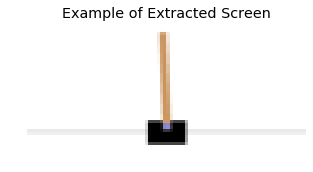

In [16]:
env.reset()
plt.figure(figsize=(5,10))
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example of Extracted Screen')
plt.axis('off')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_cart_pole_env.png')
plt.show()

## Init Screen

In [17]:
# get screen size so that we can initialize layers correctly based on the shape
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

## Initialize DQN

In [18]:
# get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=512, out_features=2, bias=True)
)

## Set Optimizer

In [19]:
optimizer = optim.RMSprop(policy_net.parameters())

## Set Configs

In [20]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

## Train DQN

In [21]:
steps_done = 0

# this will select an action accordingly to an epsilon greedy policy
def select_action(state):
    
    global steps_done
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        with torch.no_grad():
            # here the network will pick action with the larger expected reward
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long, device=device)

In [22]:
episode_durations = []

# a helper for plotting the durations of episodes
def plot_durations(i_episode):
    
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    
    plt.title(f'Training Episode: {i_episode}')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy(), color='green')
    
    # take 100 episode averages and plot them
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    
    # pause a bit so that plots are updated
    plt.savefig('./images/plot_of_training_result.png')
    plt.pause(0.001)
    if is_ipython:
        display.clear_output(wait=True)
        plt.show()

In [23]:
# this function first samples a batch, concatenates all the tensors into a single one
# then computes Q(st, at) and V(st+1) = maxaQ(st+1, a), and combines them into our loss
def optimize_network():
    
    # this will skip the optimization process if there is no enough memory
    if len(memory) < BATCH_SIZE: return
    
    transitions = memory.sample(BATCH_SIZE)
    
    # this converts batch-array of transitions to transition of batch-arrays
    batch = Transition(*zip(*transitions))
    
    # compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), dtype=torch.uint8, device=device)
    non_final_next_states = torch.cat([state for state in batch.next_state if state is not None])
    
    # concatenate all states, actions and rewards on the batch
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # compute the function Q(s_t, a)
    # the network computes Q(s_t) then will select the columns of actions (a) taken
    # The (a) is the actions which would've been taken for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    # compute V(s_{t+1}) for all next states
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # compute huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # this will perform optimization for the network
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    
    optimizer.step()

In [ ]:
def train_network(num_episodes):

    for i_episode in range(1, num_episodes+1):

        # initialize the environment and state
        env.reset()
        last_screen = get_screen()
        current_screen = get_screen()
        state = current_screen - last_screen

        for t in count():

            # select and perform an action
            action = select_action(state)
            _, reward, done, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            # observe a new state
            last_screen = current_screen
            current_screen = get_screen()
            if not done:
                next_state = current_screen - last_screen
            else:
                next_state = None

            # store the transition in memory
            memory.push(state, action, next_state, reward)

            # move to the next state
            state = next_state

            # perform one step of the optimization on the target network
            optimize_network()

            if done:
                episode_durations.append(t + 1)
                plot_durations(i_episode)
                break

            # update the target network, copying all weghts and biases in DQN
            if i_episode % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

    print('Training completed.')
    env.render()
    env.close()
    plt.ioff()
    plt.show()

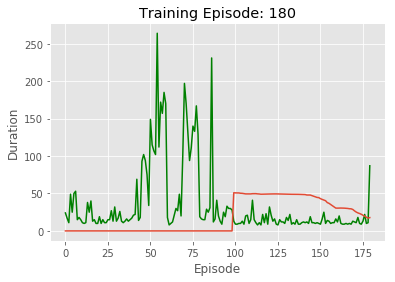

In [ ]:
print('Training the network...')
train_network(num_episodes=500)

---